# GeoNet FDSN webservice with Obspy demo - General Examples

This demo introduces some simple code that requests data using [GeoNet's FDSN webservices](http://www.geonet.org.nz/data/tools/FDSN) and the [obspy module](https://github.com/obspy/obspy/wiki) in python. This notebook uses Python 3.

### Getting Started - Import Modules

In [71]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client as FDSN_Client
from obspy import read_inventory

### Define GeoNet FDSN client

In [72]:
client = FDSN_Client("GEONET")

## Get waveform data for a specific event
This example is to demonstrate how you can use FDSN webservices to request data for a particular event. Unlike our other notebooks that demonstrate the features of each individual FDSN service this will demonstrate using multiple services to make this common request. 

First, get the event information for the earthquake. In this case, we have used the event PublicID. It can be found on the [GeoNet website](https://www.geonet.org.nz/) or through [QuakeSearch](https://quakesearch.geonet.org.nz/). 

This example will demonstrate how to get additional information about the [Kaikoura Earthquake](http://www.geonet.org.nz/earthquake/2016p858000)

In [73]:
cat = client.get_events(eventid="2016p858000")
print(cat)

1 Event(s) in Catalog:
2016-11-13T11:02:56.346094Z | -42.693, +173.022 | 7.36346279 MLv | manual


To request the waveforms from the webservice we can't use the eventid, instead we need the start and end times of the period we are interested in. This can be defined in many ways but we are going to use a window around the origin time of the event.

In [74]:
event = cat[0]
origin = event.origins[0]
otime = origin.time
print(otime)

2016-11-13T11:02:56.346094Z


Or we can do the above call all in one line.

In [75]:
otime = cat[0].origins[0].time
print(otime)

2016-11-13T11:02:56.346094Z


We probably don't want to request all available GeoNet stations. We have a lot of data! There are a few different ways to do this. Here are a couple of options. 

### Option 1: Select stations using station service
You can use the station service to get a list of stations for which you want to request data.

This example demonstrates a request for high rate (200Hz) weak motion stations within 1 degree of the earthquake.

In [76]:
inventory = client.get_stations(latitude=cat[0].origins[0].latitude,
                                longitude=cat[0].origins[0].longitude,
                                maxradius=1.0,
                                channel="HHZ",
                                level="channel",
                                starttime = otime-300,
                                endtime = otime+600)
print(inventory)

Inventory created at 2018-04-17T21:10:20.000000Z
	Created by: Delta
		    
	Sending institution: GeoNet (WEL(GNS_Test))
	Contains:
		Networks (1):
			NZ
		Stations (5):
			NZ.GVZ (Greta Valley)
			NZ.KHZ (Kahutara)
			NZ.LTZ (Lake Taylor Station)
			NZ.OXZ (Oxford)
			NZ.THZ (Top House)
		Channels (5):
			NZ.GVZ.10.HHZ, NZ.KHZ.10.HHZ, NZ.LTZ.10.HHZ, NZ.OXZ.10.HHZ,
			NZ.THZ.10.HHZ


5 Trace(s) in Stream:
NZ.GVZ.10.HHZ | 2016-11-13T10:57:54.928393Z - 2016-11-13T11:12:57.158393Z | 100.0 Hz, 90224 samples
NZ.KHZ.10.HHZ | 2016-11-13T10:57:54.278389Z - 2016-11-13T11:12:56.648389Z | 100.0 Hz, 90238 samples
NZ.LTZ.10.HHZ | 2016-11-13T10:57:52.238393Z - 2016-11-13T11:12:57.518393Z | 100.0 Hz, 90529 samples
NZ.OXZ.10.HHZ | 2016-11-13T10:57:53.203131Z - 2016-11-13T11:12:57.753131Z | 100.0 Hz, 90456 samples
NZ.THZ.10.HHZ | 2016-11-13T10:57:55.143227Z - 2016-11-13T11:12:56.353227Z | 100.0 Hz, 90122 samples


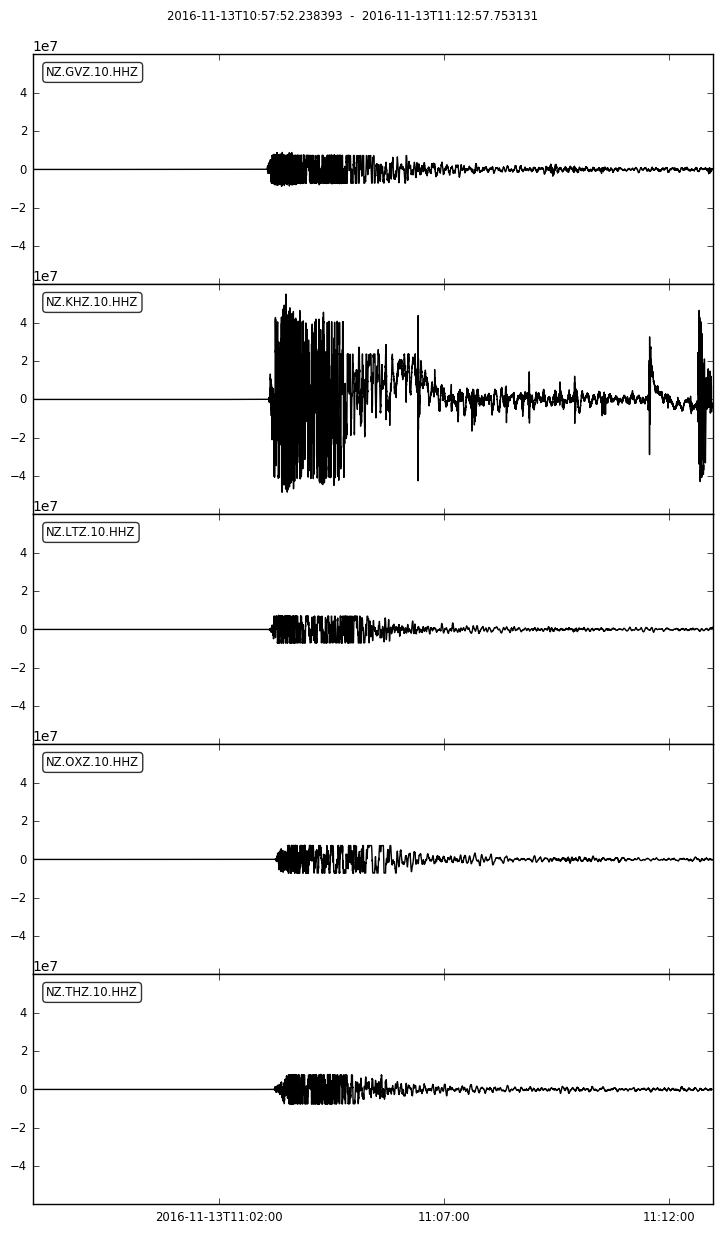

In [77]:
from obspy import Stream
st = Stream()

for network in inventory:
    for station in network:
        try:
            st += client.get_waveforms(network.code, station.code, "*", "HHZ",
                                       otime-300, otime + 600)
        except:
            pass

print(st)
st.plot()

### Option 2: Select stations using station service
You can use the arrival information to select stations to make a list of stations to request data for. 

This example demonstrates how to request stations with 1 degree that have P-wave picks. 

5 Trace(s) in Stream:
NZ.GVZ.10.HHZ | 2016-11-13T10:57:54.928393Z - 2016-11-13T11:12:57.158393Z | 100.0 Hz, 90224 samples
NZ.KHZ.10.HHZ | 2016-11-13T10:57:54.278389Z - 2016-11-13T11:12:56.648389Z | 100.0 Hz, 90238 samples
NZ.LTZ.10.HHZ | 2016-11-13T10:57:52.238393Z - 2016-11-13T11:12:57.518393Z | 100.0 Hz, 90529 samples
NZ.THZ.10.HHZ | 2016-11-13T10:57:55.143227Z - 2016-11-13T11:12:56.353227Z | 100.0 Hz, 90122 samples
NZ.OXZ.10.HHZ | 2016-11-13T10:57:53.203131Z - 2016-11-13T11:12:57.753131Z | 100.0 Hz, 90456 samples


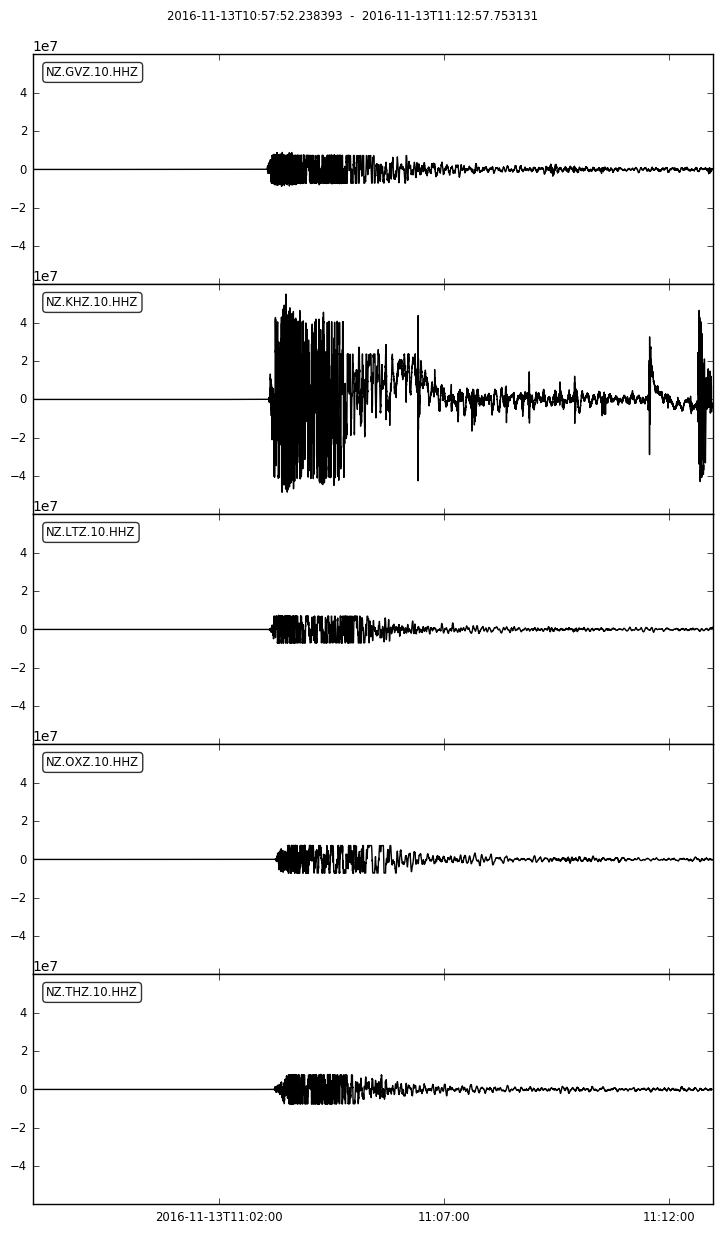

In [78]:
st = Stream()
for p in range(len(event.picks)):
    for a in range(len(origin.arrivals)):
        if event.picks[p].resource_id == origin.arrivals[a].pick_id:
            if origin.arrivals[a].phase == 'P' and  origin.arrivals[a].distance <= 1.0:
                try:
                    st += client.get_waveforms("NZ", event.picks[p].waveform_id['station_code'], "*", "HHZ",
                                       otime-300, otime + 600)
                except:
                    pass
print(st)
st.plot()